In [7]:
import torch
from torchsynth.config import SynthConfig
from dataset import chains

config = SynthConfig(batch_size=1, sample_rate=48000, reproducible=False)
synth = chains.SimpleSynth(config)
data = torch.load('/home/ubuntu/Sound2Synth/data/SimpleSynth/train/processed/sound_0.pt')

In [20]:
param, _ = data['label']
unnormalized_param = []
for p ,(k, v) in zip(param,synth.get_parameters().items()):
    unnormalizer = v.parameter_range
    unnormalized = unnormalizer.from_0to1(p)
    unnormalized_param.append(unnormalized)
print(torch.tensor(unnormalized_param))

tensor([ 4.8038e-01,  8.0411e-01,  7.6822e-01,  3.9141e-02,  1.9138e+00,
         6.0000e+01,  3.0000e+00, -7.2531e+00, -5.2643e-04,  2.4909e+00,
         6.3231e-01])


In [1]:
import os
import torch
import torchaudio
from pytorch_lightning import Trainer
from dataset import DATASET_MAPPING, DATASET_PATHS
from interface import INTERFACE_MAPPING
from model import Net, get_backbone, get_classifier
from sound2synth import Sound2SynthModel
from pathlib import Path
from pyheaven import *
from dataset.chains import SimpleSynth, Synplant2
from interface.torchsynth import REG_NCLASS
from torchsynth.config import SynthConfig


def load_checkpoint(checkpoint_path, args):
    interface = INTERFACE_MAPPING[args.synth]
    net = Net(
        backbone=get_backbone(args.backbone, args),
        classifier=get_classifier(args.classifier, interface, args),
    )
    model = Sound2SynthModel.load_from_checkpoint(checkpoint_path, net=net, interface=interface, args=args)
    return model

def save_wavs(audio, path, name):
    os.makedirs(path, exist_ok=True)
    filepath = os.path.join(path, f"{name}.wav")
    torchaudio.save(filepath, audio, 48000)
    
def parse_outputs(outputs, unnormalizer, logits, from_0to1):
    n_params = len(unnormalizer)
    # print(n_params)
    if logits:
        outputs = torch.stack(outputs.squeeze(0).chunk(n_params)).argmax(dim=1)/(REG_NCLASS-1)
    
    mydict = {}
    assert len(unnormalizer) == len(outputs), f"Length mismatch: {len(unnormalizer)} vs {len(outputs)}"
    for (k, f), v in zip(unnormalizer.items(), outputs):
        if 'keyboard' in k:
            continue # Skip keyboard parameters as they are initialized frozen
        mydict[k] = f.from_0to1(v.unsqueeze(0)) if from_0to1 else v.unsqueeze(0)
    return mydict

def dict_to_audio(mydict, synth):
    synth.set_parameters(mydict)
    # print(synth.keyboard.torchparameters.midi_f0)
    audio = synth.output()
    return audio

# def main():
if True:
    checkpoint_path = './checkpoints/SimpleSynth_audioLoss/last.ckpt'  # Replace with the actual path to the checkpoint
    output_dir = "output_wavs"
    
    args = MemberDict(dict(
        synth="TorchSynth",
        synth_class="SimpleSynth",
        backbone="multimodal",
        classifier="parameter",
        dataset_type="my_multimodal",
        dataset="SimpleSynth",
        feature_dim=2048,
    ))
    
    dataset = DATASET_MAPPING[args.dataset_type](dir='data/'+args.dataset, chain=args.synth_class, split='train')
    
    synth = dataset.synth
    unnormalizer = dataset.unnormalizer

    model = load_checkpoint(checkpoint_path, args)
    model.eval()

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)
    
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            if idx >= 5:  # Iterate through 5 samples
                break
            (features, sample_rate), label = batch
            outputs = model(features)
            true_params = label[0].squeeze(0)
            # print((true_params.max() <= 1).item())
            parsed_outputs = parse_outputs(outputs, unnormalizer, logits=True, from_0to1=True)
            parsed_true_params = parse_outputs(true_params, unnormalizer, logits=False, from_0to1=(true_params.max() <= 1).item())

            print(parsed_outputs)
            print(parsed_true_params)

            reconstructions = dict_to_audio(parsed_outputs, synth)
            ground_truth = dict_to_audio(parsed_true_params, synth)
            
            # Save ground truth and reconstructions as WAV files
            save_wavs(ground_truth, output_dir, f"ground_truth_{idx}")
            save_wavs(reconstructions, output_dir, f"reconstruction_{idx}")
            print(f"Saved sample {idx}")

# main()

/home/ubuntu/anaconda3/envs/sound2synth/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/ubuntu/anaconda3/envs/sound2synth/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/ubuntu/anaconda3/envs/sound2synth/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/ubuntu/anaconda3/envs/sound2synth/lib

KeyboardInterrupt: 

In [1]:
from dataset.chains import SimpleSynth
from torchsynth.config import SynthConfig
import torch
import torch.nn.functional as F
from pyheaven import *
from dataset import DATASET_MAPPING, DATASET_PATHS
from interface.torchsynth import REG_NCLASS

args = MemberDict(dict(
        synth="TorchSynth",
        synth_class="SimpleSynth",
        backbone="multimodal",
        classifier="parameter",
        dataset_type="my_multimodal",
        dataset="SimpleSynth",
        feature_dim=2048,
))

dataset = DATASET_MAPPING[args.dataset_type](dir='data/'+args.dataset, chain=args.synth_class, split='train')

unnormalizer = dataset.unnormalizer

class DifferentiableArgmax(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        idx = input.argmax(dim=1)
        output = F.one_hot(idx, num_classes=input.size(1)).float()
        ctx.save_for_backward(input, output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, output = ctx.saved_tensors
        grad_input = grad_output * output
        return grad_input

def parse_outputs(outputs, unnormalizer, logits, from_0to1):
    n_params = len(unnormalizer)
    if logits:
        outputs = torch.stack(outputs.squeeze(0).chunk(n_params))
        # print("Grad function after stacking:", outputs.grad_fn)
        
        # Apply DifferentiableArgmax
        outputs_one_hot = DifferentiableArgmax.apply(outputs)
        # print("Grad function after DifferentiableArgmax:", outputs_one_hot.grad_fn)
        
        # Convert one-hot back to index and normalize
        outputs = outputs_one_hot.argmax(dim=1).float() / (REG_NCLASS - 1)
        # print("Grad function after conversion and normalization:", outputs.grad_fn)
        
        # Ensure outputs requires grad
        if not outputs.requires_grad:
            outputs = outputs.detach().requires_grad_()
        
        # print("Final grad function:", outputs.grad_fn)
    
    mydict = {}
    assert len(unnormalizer) == len(outputs), f"Length mismatch: {len(unnormalizer)} vs {len(outputs)}"
    for (k, f), v in zip(unnormalizer.items(), outputs):
        if 'keyboard' in k:
            continue # Skip keyboard parameters as they are initialized frozen
        mydict[k] = f.from_0to1(v.unsqueeze(0)) if from_0to1 else v.unsqueeze(0)
    return mydict

outputs = torch.randn((1,704), requires_grad=True)
params = parse_outputs(outputs, unnormalizer, logits=True, from_0to1=True)

synth = SimpleSynth(SynthConfig(batch_size=1, sample_rate=48000, reproducible=False, no_grad=False))

synth.set_parameters(params)
set_params = synth.get_parameters()
for k, v in params.items():
    print(v.grad_fn)


Module, received value grad fn: None
ModuleParameter(name=midi_f0, value=tensor([0.4583, 0.1176, 0.1306, 0.3014, 0.2810, 0.6898, 0.5162, 0.5739, 0.2169,
        0.1588, 0.2780, 0.2170, 0.6408, 0.8248, 0.9159, 0.4198, 0.4051, 0.0019,
        0.4069, 0.9857, 0.6629, 0.7878, 0.5834, 0.0461, 0.2492, 0.4795, 0.0817,
        0.4352, 0.5693, 0.9458, 0.5966, 0.0411]))
Pre-existing grad fn: None
Parameter received grad_fn: None
Parameter returning grad_fn: None
Post grad fn: None
Module set value grad fn: None
Module, received value grad fn: None
ModuleParameter(name=duration, value=tensor([0.7447, 0.9775, 0.0298, 0.8694, 0.2186, 0.0291, 0.0573, 0.4556, 0.9365,
        0.3590, 0.9447, 0.9639, 0.6449, 0.8985, 0.6730, 0.2891, 0.7008, 0.0180,
        0.3277, 0.5703, 0.6723, 0.8760, 0.7086, 0.9030, 0.4321, 0.4253, 0.6631,
        0.9869, 0.5455, 0.2964, 0.1566, 0.3552]))
Pre-existing grad fn: None
Parameter received grad_fn: None
Parameter returning grad_fn: None
Post grad fn: None
Module set value

In [47]:
outputs = torch.randn(1, 11)
argmax = outputs.argmax(dim=-1)
softmax = outputs.softmax(dim=-1)
softmax = (softmax * torch.linspace(0, 1, softmax.shape[-1], device=softmax.device)).sum(dim=-1)
print(outputs, argmax, softmax)

tensor([[ 1.5737, -0.2365,  1.2066,  0.8111, -0.3006, -0.3348,  0.7711, -0.2459,
         -0.4521, -0.0867, -0.0980]]) tensor([0]) tensor([0.3411])


In [36]:
%load_ext autoreload
%autoreload 2

from utils.loss_utils import AudioLoss

pred_params = torch.randn(1, 64*44)

loss_fn = AudioLoss(scales=[512,1024], synth='Synplant2')

loss, stfts = loss_fn(pred_params, true_params)
# for stft in stfts:
#     print(f'Max: {stft[0].max()}, Min: {stft[0].min()}')
print(loss)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Signal(4.9198, grad_fn=<AliasBackward0>)


In [30]:
stfts[0]

[Signal([[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<AliasBackward0>),
 Signal([[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<AliasBackward0>)]

In [29]:
pred_stft.isnan().sum()

Signal(0)

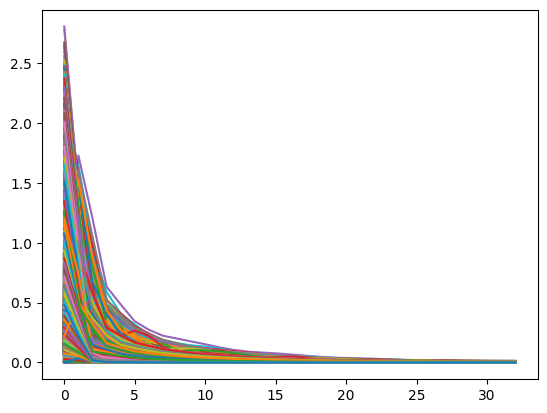

In [26]:
import matplotlib.pyplot as plt
# plt.plot(true_audio[0].detach().numpy())
# plt.plot(pred_audio[0].detach().numpy())
plt.plot(pred_stft[0].detach().numpy())
plt.show()

In [22]:
import math

def estimate_avg_nearest_neighbor_distance(n, k):
    return math.gamma(1 + 1/k) * (n ** (-1/k))

# Example usage
n = 8000 # number of samples
k = 9     # number of dimensions
avg_distance = estimate_avg_nearest_neighbor_distance(n, k)
print(f"Estimated average distance to nearest neighbor: {avg_distance}")

Estimated average distance to nearest neighbor: 0.3488650173108152


In [28]:
import math

def combinations_with_replacement(n, r):
    return math.comb(n + r - 1, r)

# 1. n=8000, r=9
n1, r1 = 64, 42
result1 = combinations_with_replacement(n1, r1)
print(f"Combinations with replacement for n={n1}, r={r1}: {result1}")

# 2. n=8000, r=42
n2, r2 = 64, 300
result2 = combinations_with_replacement(n2, r2)
print(f"Combinations with replacement for n={n2}, r={r2}: {result2}")
result2/result1


Combinations with replacement for n=64, r=42: 388212866177054207116394767200
Combinations with replacement for n=64, r=300: 311394499632398271591993532000006491918850991174251883490285708155690256


8.021230792757368e+41

In [3]:
import os

def get_file_sizes(folder_path):
    file_sizes = {}
    
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                file_size = os.path.getsize(file_path)
                file_sizes[file_path] = file_size
            except OSError as e:
                print(f"Error getting size of {file_path}: {e}")

    return file_sizes

folder_path = '/home/ubuntu/Sound2Synth/data/Synplant2_big/test/processed'  # Replace with your folder path
file_sizes = get_file_sizes(folder_path)

for file_path, size in file_sizes.items():
    if size == 155648:
        print(f"{file_path}: {size} bytes")
# print(set(file_sizes.values()))

/home/ubuntu/Sound2Synth/data/Synplant2_big/test/processed/sound_101876.pt: 155648 bytes


In [4]:
from dataset.chains import SimpleSynth
from torchsynth.config import SynthConfig

synth = SimpleSynth(SynthConfig(batch_size=1, sample_rate=48000, reproducible=False))
synth.keyboard.torchparameters.midi_f0
# print(synth.monophonic_keyboard.torchparameters.midi_f0)

ModuleParameter(name=midi_f0, value=tensor([0.4724]))

In [10]:
torch.load('/home/ubuntu/Sound2Synth/data/Synplant2/train/processed/sound_0.pt')['label'][0]

tensor([0.4724, 0.8657, 0.1759, 0.2698, 0.0317, 0.1507, 0.9320, 0.6341, 0.4901,
        0.4556, 0.8964, 0.3074, 0.2081, 0.7231, 0.9298, 0.2437, 0.0332, 0.5263,
        0.7423, 0.5846, 0.6323, 0.4017, 0.3489, 0.2939, 0.6977, 0.1689, 0.0223,
        0.5185, 0.8742, 0.3971, 0.9152, 0.8000, 0.2823, 0.6816, 0.1610, 0.3051,
        0.3734, 0.1852, 0.4194, 0.9527, 0.0362, 0.5529, 0.0885, 0.1320])

In [3]:
from dataset.chains import Voice
from torchsynth.config import SynthConfig

params = []
synth = Voice(SynthConfig(batch_size=1, sample_rate=48000, reproducible=False))
for k, v in synth.named_parameters():
    k = k.split('.')
    k = (k[0], k[-1])
    params.append(k)
# print(params)

[('keyboard', 'midi_f0'), ('keyboard', 'duration'), ('adsr_1', 'attack'), ('adsr_1', 'decay'), ('adsr_1', 'sustain'), ('adsr_1', 'release'), ('adsr_1', 'alpha'), ('adsr_2', 'attack'), ('adsr_2', 'decay'), ('adsr_2', 'sustain'), ('adsr_2', 'release'), ('adsr_2', 'alpha'), ('lfo_1', 'frequency'), ('lfo_1', 'mod_depth'), ('lfo_1', 'initial_phase'), ('lfo_1', 'sin'), ('lfo_1', 'tri'), ('lfo_1', 'saw'), ('lfo_1', 'rsaw'), ('lfo_1', 'sqr'), ('lfo_2', 'frequency'), ('lfo_2', 'mod_depth'), ('lfo_2', 'initial_phase'), ('lfo_2', 'sin'), ('lfo_2', 'tri'), ('lfo_2', 'saw'), ('lfo_2', 'rsaw'), ('lfo_2', 'sqr'), ('lfo_1_amp_adsr', 'attack'), ('lfo_1_amp_adsr', 'decay'), ('lfo_1_amp_adsr', 'sustain'), ('lfo_1_amp_adsr', 'release'), ('lfo_1_amp_adsr', 'alpha'), ('lfo_2_amp_adsr', 'attack'), ('lfo_2_amp_adsr', 'decay'), ('lfo_2_amp_adsr', 'sustain'), ('lfo_2_amp_adsr', 'release'), ('lfo_2_amp_adsr', 'alpha'), ('lfo_1_rate_adsr', 'attack'), ('lfo_1_rate_adsr', 'decay'), ('lfo_1_rate_adsr', 'sustain'), (

In [ ]:
output_dir = "output_wavs"
    
args = MemberDict(dict(
    synth="TorchSynth",
    backbone="multimodal",
    classifier="parameter",
    dataset_type="my_multimodal",
    dataset="Synplant2",
    feature_dim=2048,
))

dataset = DATASET_MAPPING[args.dataset_type](dir=DATASET_PATHS[args.dataset], split='test')

unnormalizer = {}
synth = SimpleSynth(SynthConfig(batch_size=1, sample_rate=48000, reproducible=False))
for k, v in synth.named_parameters():
    k = k.split('.')
    k = (k[0], k[-1])
    unnormalizer[k] = v.parameter_range

model = load_checkpoint(checkpoint_path, args)
model.eval()

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

for idx, batch in enumerate(dataloader):
    if idx >= 50:  # Iterate through 5 samples
        break
    (features, sample_rate), label = batch

    true_params = label[0]
    parsed_true_params = parse_outputs(true_params, unnormalizer, logits=False, from_0to1=(true_params.max() <= 1).item())
    ground_truth = dict_to_audio(parsed_true_params, synth)
    
    # Save ground truth and reconstructions as WAV files
    save_wavs(ground_truth, output_dir, f"ground_truth_{idx}")
    print(f"Saved sample {idx}")

In [ ]:
from dataset.chains import SimpleSynth
from torchsynth.config import SynthConfig

unnormalizer = {}
synth = SimpleSynth(SynthConfig(batch_size=1, sample_rate=48000, reproducible=False))
for k, v in synth.named_parameters():
    k = k.split('.')
    k = (k[0], k[-1])
    unnormalizer[k] = v.parameter_range
unnormalizer
# next(synth.named_parameters())

In [3]:
from torchsynth.module import MonophonicKeyboard
from torchsynth.config import SynthConfig
import torch

params = {"midi_f0": torch.tensor([60.0]), "duration": torch.tensor([3.0])}
keyboard = MonophonicKeyboard(SynthConfig(batch_size=1, sample_rate=48000, reproducible=False), **params)

keyboard.get_parameter("midi_f0").from_0to1()

tensor([60.], grad_fn=<AddBackward0>)

In [19]:
params = []
for n in range(5):
    data = torch.load(f'/home/ubuntu/Sound2Synth/data/Synplant2/train/unprocessed/sound_{n}.pt')
    params.append(data['params'])
torch.stack(params).shape

torch.Size([5, 44])